# <div align="center"> **ANALISIS PERGERAKAN HARGA SAHAM PT MEDCO ENERGI INTERNASIONAL TBK DARI TAHUN 2015 HINGGA FEBRUARI 2023 MENGGUNAKAN ALGORITMA TEMPORAL CONVOLUTIONAL NETWORK** </div>
# <div align="center"> UAS IF540 MACHINE LEARNING </div>
# <div align="center"> Semester Genap 2022/2023 </div>

KELOMPOK C :
- Reina Ratu Balqis (00000065099)
- Gempar Bambang Godata (00000067643)
- Azzahra Shaffira Wijaya (00000055376)
- Marselinus Bayu Prasetya (00000042982)




# **Install Packages**

In [1]:
!pip install yfinance
!pip install yahoofinancials
!pip install keras-tcn
!pip install keras-tuner


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for yahoofinancials: filename=yahoofinancials-1.14-py3-none-any.whl size=28627 sha256=5c4f3866275de9e712912159aa63a1ea0df2d3479f776a8f49dfe34d1f4c6b39
  Stored in directory: /root/.cache/pip/wheels/32/a3/b6/b5b33187f2d42f095fecc236b957b46173fa09e78a106e309f
Successfully built yahoofinancials
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.1 MB/s eta 0:00:00


# **Import**

## Import libraries

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, Dense, Flatten, MaxPooling1D, Input
from tensorflow.keras.models import Model 
from keras_tuner.tuners import RandomSearch
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## Download data from Yahoo Finance

In [3]:
medc_df = yf.download('MEDC.JK', start='2015-01-01', end='2023-02-28')
medc_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,695.238159,708.571472,685.714355,706.666748,665.745422,1822799
2015-01-05,687.619141,700.952454,686.666748,687.619141,647.800842,2555699
2015-01-06,676.190552,681.904846,670.476257,676.190552,637.034058,3680774
2015-01-07,676.190552,676.190552,646.666748,649.523865,611.911560,9209549
2015-01-08,657.142944,657.142944,640.000061,645.714355,608.322693,2059574
...,...,...,...,...,...,...
2023-02-21,1070.000000,1095.000000,1055.000000,1065.000000,1065.000000,86971300
2023-02-22,1065.000000,1085.000000,1050.000000,1060.000000,1060.000000,73596800
2023-02-23,1050.000000,1060.000000,1020.000000,1060.000000,1060.000000,85288800


# **Feature Selection**


## Ambil Kolom Close

In [4]:
data = medc_df[['Close']].values
data

array([[ 706.66674805],
       [ 687.61914062],
       [ 676.19055176],
       ...,
       [1060.        ],
       [1105.        ],
       [1115.        ]])

In [5]:
medc_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2039 entries, 2015-01-02 to 2023-02-27
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2039 non-null   float64
 1   High       2039 non-null   float64
 2   Low        2039 non-null   float64
 3   Close      2039 non-null   float64
 4   Adj Close  2039 non-null   float64
 5   Volume     2039 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 111.5 KB


# **Visualisasi Data**

## Memplot setiap atribut Dataset

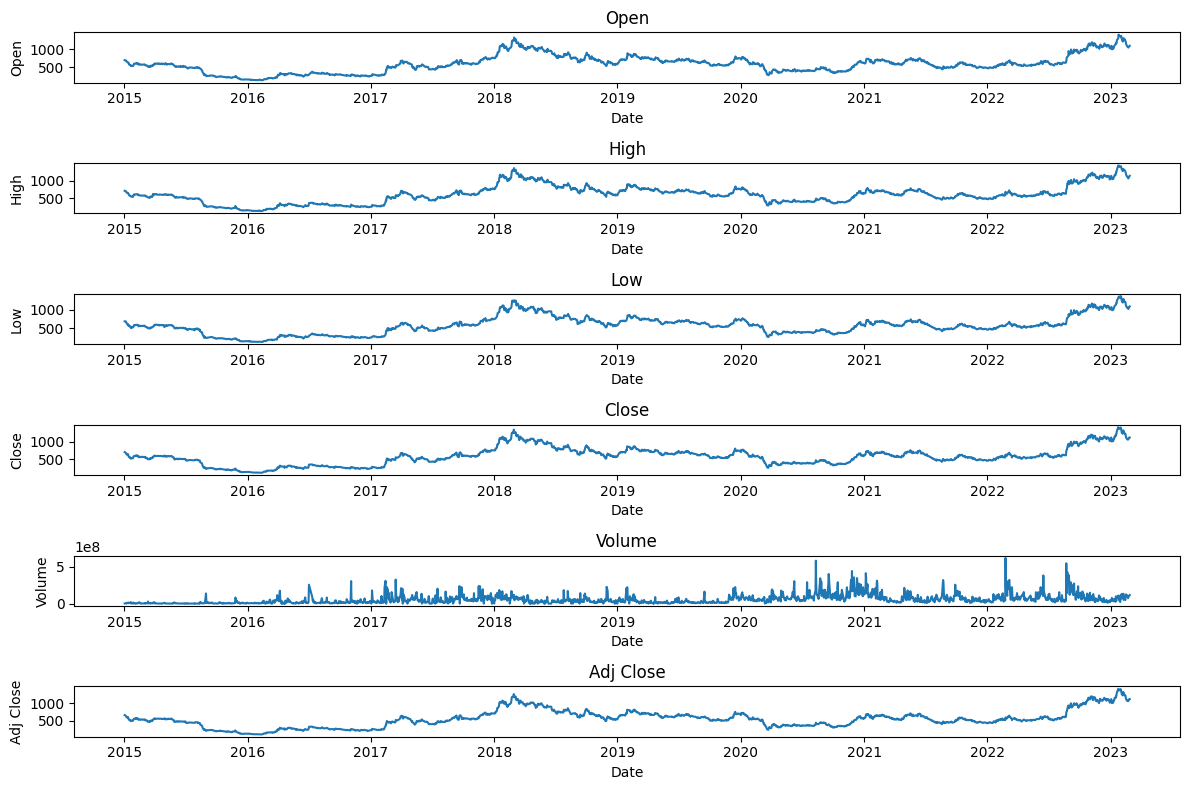

In [ ]:
attributes = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']

plt.figure(figsize=(12, 8))

for i, attr in enumerate(attributes):
    plt.subplot(len(attributes), 1, i + 1)
    plt.plot(medc_df.index, medc_df[attr])
    plt.xlabel('Date')
    plt.ylabel(attr)
    plt.title(attr)

plt.tight_layout()
plt.show()


## Enumerasi Data

In [ ]:
# Menghitung persentase perubahan harga
medc_df['Return'] = medc_df['Close'].pct_change() * 100

# Menentukan batas kategori
threshold_good = 2.0  # Saham dengan persentase perubahan > 1% dikategorikan sebagai "baik"
threshold_bad = -2.0  # Saham dengan persentase perubahan < -1% dikategorikan sebagai "buruk"

# Membuat kolom "Kategori"
medc_df['Kategori'] = 'Biasa'  # Saham dengan persentase perubahan antara -1% dan 1% dikategorikan sebagai "biasa"
medc_df.loc[medc_df['Return'] > threshold_good, 'Kategori'] = 'Bagus'
medc_df.loc[medc_df['Return'] < threshold_bad, 'Kategori'] = 'Buruk'

# Menampilkan data dengan kategori
print(medc_df[['Close', 'Return', 'Kategori']])


                  Close    Return Kategori
Date                                      
2015-01-02   706.666748       NaN    Biasa
2015-01-05   687.619141 -2.695416    Buruk
2015-01-06   676.190552 -1.662052    Biasa
2015-01-07   649.523865 -3.943665    Buruk
2015-01-08   645.714355 -0.586508    Biasa
...                 ...       ...      ...
2023-02-21  1065.000000  0.471698    Biasa
2023-02-22  1060.000000 -0.469484    Biasa
2023-02-23  1060.000000  0.000000    Biasa
2023-02-24  1105.000000  4.245283    Bagus
2023-02-27  1115.000000  0.904977    Biasa

[2039 rows x 3 columns]


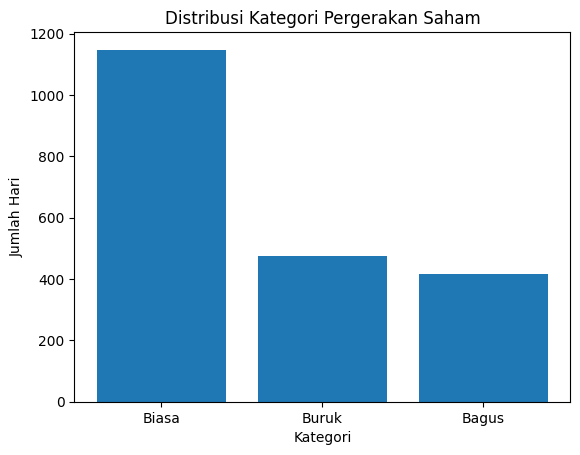

In [ ]:
# Menghitung jumlah baris dalam setiap kategori
kategori_counts = medc_df['Kategori'].value_counts()

# Membuat bar plot
plt.bar(kategori_counts.index, kategori_counts.values)
plt.xlabel('Kategori')
plt.ylabel('Jumlah Hari')
plt.title('Distribusi Kategori Pergerakan Saham')
plt.show()


# **Correlation Test**

## Correlation Heatmap

<Axes: >

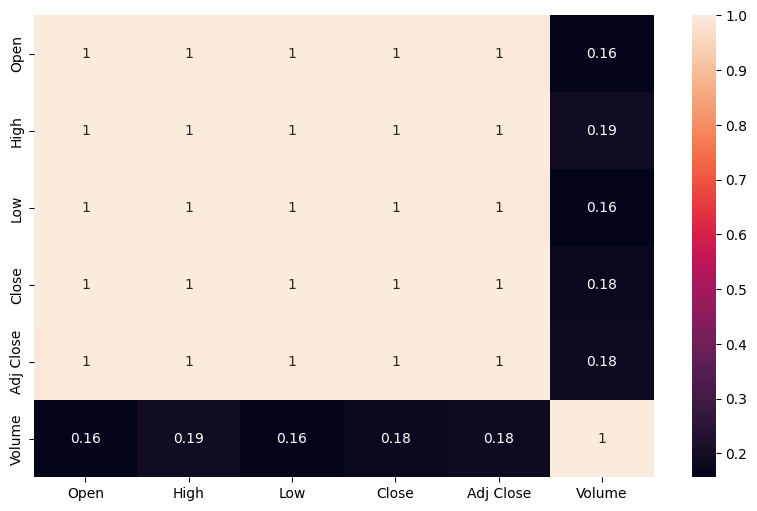

In [ ]:
f,ax=plt.subplots(figsize=(10,6))
sns.heatmap(medc_df.corr(), annot=True)

# **Preprocessing Data**

## Bagi data test dan data training 

In [6]:
data = data.reshape(-1, 1)  # Reshape data to (samples, features)
train_size = int(len(data) * 0.3)  # 30% train, 70% test
train_data = data[:train_size]
test_data = data[train_size:]

# Create sequences for training
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# **Validasi Model**


## Membangun Model

In [ ]:
def build_model(hp):
    input_layer = Input(shape=(seq_length, 1))
    conv1 = Conv1D(filters=hp.Int('filters', 
                                  min_value=32, max_value=256, step=32),
                       kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
                       activation='relu')(input_layer)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    flatten = Flatten()(pool1)
    output_layer = Dense(1)(flatten)
    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', 
                                                values=[1e-2, 1e-3, 1e-4])),
                  loss='mse')

    return model


## Tuning Model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    directory='tuner_directory',
    project_name='tcn_tuning'
)

In [ ]:

tuner.search(X_train, y_train, epochs=100, 
             validation_data=(X_test, y_test), batch_size=40)

Trial 10 Complete [00h 00m 30s]
val_loss: 2369.7080078125

Best val_loss So Far: 809.9010620117188
Total elapsed time: 00h 05m 34s


In [ ]:
tuner.results_summary()

Results summary
Results in tuner_directory/tcn_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 03 summary
Hyperparameters:
filters: 256
kernel_size: 3
learning_rate: 0.01
Score: 809.9010620117188

Trial 05 summary
Hyperparameters:
filters: 96
kernel_size: 3
learning_rate: 0.01
Score: 824.5476684570312

Trial 01 summary
Hyperparameters:
filters: 64
kernel_size: 3
learning_rate: 0.01
Score: 856.4832763671875

Trial 07 summary
Hyperparameters:
filters: 192
kernel_size: 3
learning_rate: 0.001
Score: 955.5147094726562

Trial 08 summary
Hyperparameters:
filters: 192
kernel_size: 7
learning_rate: 0.001
Score: 1022.6117553710938

Trial 00 summary
Hyperparameters:
filters: 96
kernel_size: 3
learning_rate: 0.001
Score: 1100.5531005859375

Trial 09 summary
Hyperparameters:
filters: 192
kernel_size: 5
learning_rate: 0.0001
Score: 2369.7080078125

Trial 02 summary
Hyperparameters:
filters: 160
kernel_size: 5
learning_rate: 0.0001
Score: 2794.404296875

Trial 06 summ

# **Prediksi Data**

## Training dan Testing Data Model

### Gunakan model untuk prediksi

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

best_model.fit(X_train, y_train, epochs=100, batch_size=40)

predictions = best_model.predict(X_test)


Epoch 1/100
14/14 [==============================] - 1s 10ms/step - loss: 444.8291
Epoch 2/100
14/14 [==============================] - 0s 9ms/step - loss: 521.9675
Epoch 3/100
14/14 [==============================] - 0s 10ms/step - loss: 582.8329
Epoch 4/100
14/14 [==============================] - 0s 9ms/step - loss: 357.8786
Epoch 5/100
14/14 [==============================] - 0s 10ms/step - loss: 260.4881
Epoch 6/100
14/14 [==============================] - 0s 9ms/step - loss: 295.1114
Epoch 7/100
14/14 [==============================] - 0s 9ms/step - loss: 259.9379
Epoch 8/100
14/14 [==============================] - 0s 10ms/step - loss: 339.2717
Epoch 9/100
14/14 [==============================] - 0s 9ms/step - loss: 291.1970
Epoch 10/100
14/14 [==============================] - 0s 10ms/step - loss: 299.3723
Epoch 11/100
14/14 [==============================] - 0s 9ms/step - loss: 331.6040
Epoch 12/100
14/14 [==============================] - 0s 9ms/step - loss: 266.2177
Epoch 13

### Visualisasi Hasil Testing

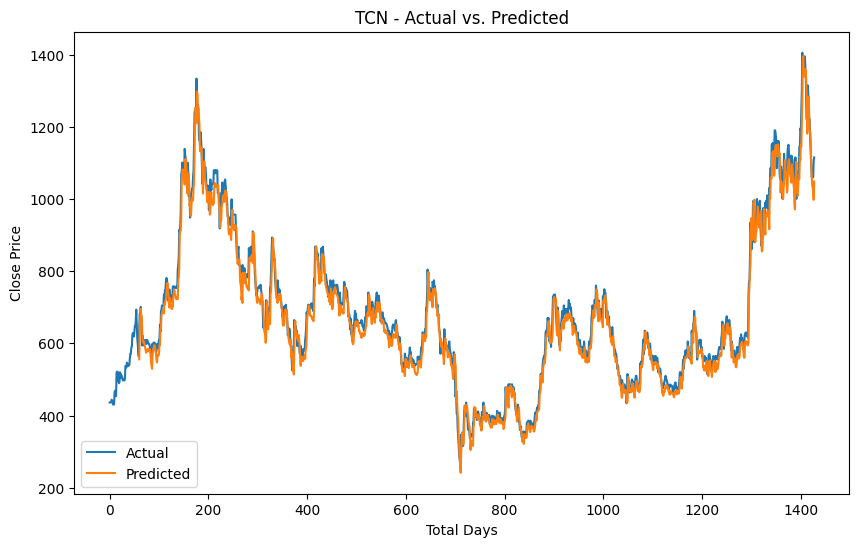

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test_data, label='Actual')
plt.plot(range(seq_length, len(test_data)), predictions, label='Predicted')
plt.xlabel('Total Days')
plt.ylabel('Close Price')
plt.title('TCN - Actual vs. Predicted')
plt.legend()
plt.show()


### Akurasi Model

In [ ]:
# Best Model 

# Menghitung R2 score
r2 = r2_score(y_test, predictions)

# Menghitung MSE
mse = mean_squared_error(y_test, predictions)

# Menghitung MAE
mae = mean_absolute_error(y_test, predictions)

print("R2 Score:", r2)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

R2 Score: 0.9770937711935798
Mean Squared Error: 1072.5917669375597
Mean Absolute Error: 24.722298650016562


## Forecasting

### Forecasting untuk 60 hari kedepan

In [ ]:
last_sequence = data[-seq_length:].reshape(1, seq_length, 1)
forecast = []
for _ in range(60):
    pred = best_model.predict(last_sequence)
    forecast.append(pred[0][0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0][-1] = pred[0][0]



1/1 [==============================] - 0s 25ms/step


### Visualisasi Forecasting

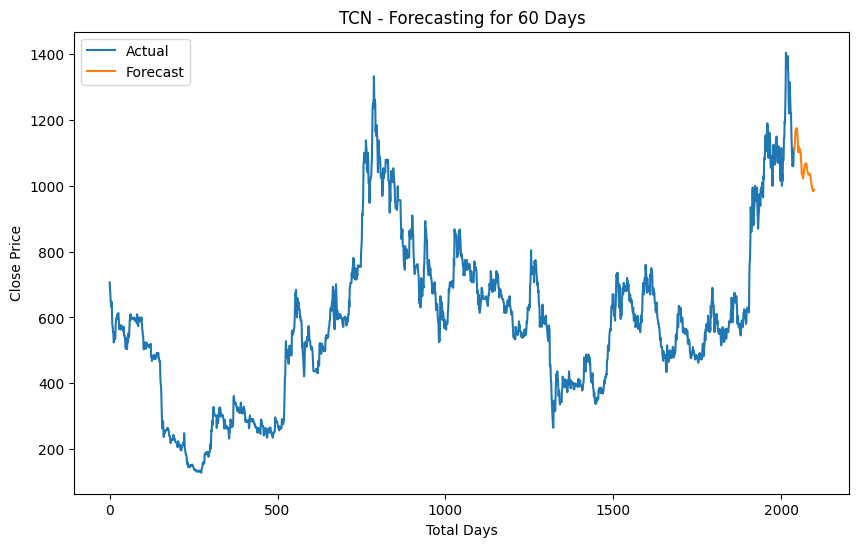

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data, label='Actual')
plt.plot(range(len(data), len(data) + 60), forecast, label='Forecast')
plt.xlabel('Total Days')
plt.ylabel('Close Price')
plt.title('TCN - Forecasting for 60 Days')
plt.legend()
plt.show()

## Training Loss dan Validation Loss

### Compile and train the model with validation

In [ ]:
best_model.compile(optimizer=Adam(), loss='mse')
history = best_model.fit(X_train, y_train, epochs=100, batch_size=40, validation_data=(X_test, y_test))

# Get validation loss
val_loss = history.history['val_loss']

Epoch 1/100
14/14 [==============================] - 1s 27ms/step - loss: 330.4971 - val_loss: 1414.1858
Epoch 2/100
14/14 [==============================] - 0s 22ms/step - loss: 276.1749 - val_loss: 885.8379
Epoch 3/100
14/14 [==============================] - 0s 18ms/step - loss: 230.6253 - val_loss: 824.8251
Epoch 4/100
14/14 [==============================] - 0s 22ms/step - loss: 229.0264 - val_loss: 795.8411
Epoch 5/100
14/14 [==============================] - 0s 22ms/step - loss: 245.0777 - val_loss: 881.6322
Epoch 6/100
14/14 [==============================] - 0s 22ms/step - loss: 229.6505 - val_loss: 796.4492
Epoch 7/100
14/14 [==============================] - 0s 18ms/step - loss: 232.8835 - val_loss: 912.8544
Epoch 8/100
14/14 [==============================] - 0s 22ms/step - loss: 240.2752 - val_loss: 806.1246
Epoch 9/100
14/14 [==============================] - 0s 21ms/step - loss: 239.2637 - val_loss: 788.7297
Epoch 10/100
14/14 [==============================] - 0s 22ms/s

### Training Loss dan Validation Loss

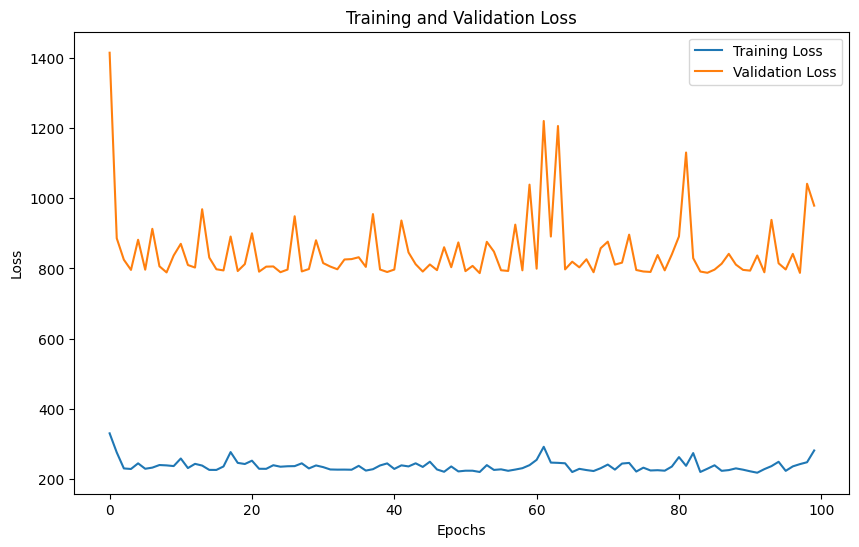

In [ ]:
# Plot training loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Best Model rank 5

In [12]:
# Build TCN model
input_layer = Input(shape=(seq_length, 1))
conv1 = Conv1D(filters=192, kernel_size=7, activation='relu')(input_layer)
pool1 = MaxPooling1D(pool_size=2)(conv1)
flatten = Flatten()(pool1)
output_layer = Dense(1)(flatten)
best_model5 = Model(inputs=input_layer, outputs=output_layer)

# Compile and train the model
best_model5.compile(optimizer=Adam(learning_rate=1e-3),loss='mse')
best_model5.fit(X_train, y_train, epochs=100, batch_size=40)

# Predict on test data
predictions5 = best_model5.predict(X_test)

Epoch 1/100
14/14 [==============================] - 1s 10ms/step - loss: 55257.6133
Epoch 2/100
14/14 [==============================] - 0s 9ms/step - loss: 11022.5830
Epoch 3/100
14/14 [==============================] - 0s 10ms/step - loss: 7604.1880
Epoch 4/100
14/14 [==============================] - 0s 15ms/step - loss: 5827.2954
Epoch 5/100
14/14 [==============================] - 0s 14ms/step - loss: 4940.6294
Epoch 6/100
14/14 [==============================] - 0s 14ms/step - loss: 4367.8296
Epoch 7/100
14/14 [==============================] - 0s 14ms/step - loss: 3905.5276
Epoch 8/100
14/14 [==============================] - 0s 12ms/step - loss: 3321.5317
Epoch 9/100
14/14 [==============================] - 0s 13ms/step - loss: 2942.4329
Epoch 10/100
14/14 [==============================] - 0s 14ms/step - loss: 2710.8228
Epoch 11/100
14/14 [==============================] - 0s 14ms/step - loss: 2522.0349
Epoch 12/100
14/14 [==============================] - 0s 13ms/step - loss

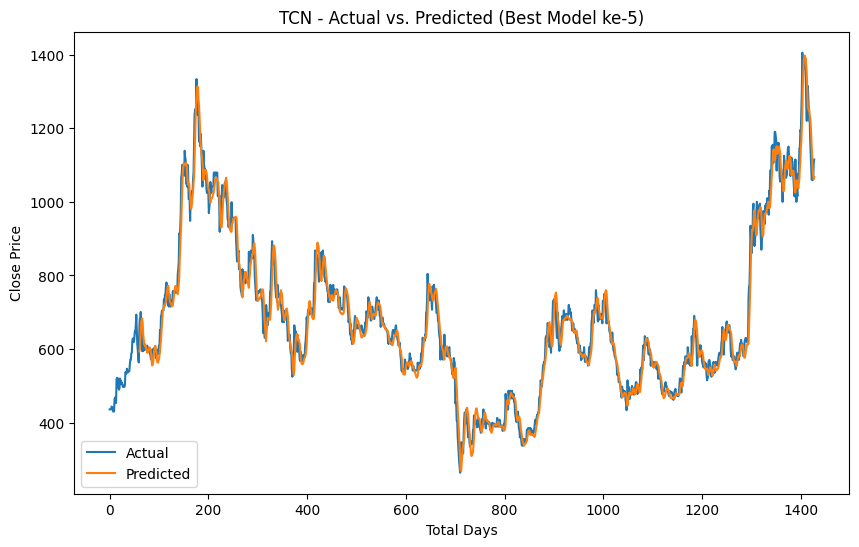

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(test_data, label='Actual')
plt.plot(range(seq_length, len(test_data)), predictions5, label='Predicted')
plt.xlabel('Total Days')
plt.ylabel('Close Price')
plt.title('TCN - Actual vs. Predicted (Best Model ke-5)')
plt.legend()
plt.show()


In [14]:
# Best Model Rank 5

# Menghitung R2 score
r2 = r2_score(y_test, predictions5)

# Menghitung MSE
mse = mean_squared_error(y_test, predictions5)

# Menghitung MAE
mae = mean_absolute_error(y_test, predictions5)

print("R2 Score Best Model ke-5:", r2)
print("Mean Squared Error Best Model ke-5:", mse)
print("Mean Absolute Error Best Model ke-5:", mae)

R2 Score Best Model ke-5: 0.974282086962903
Mean Squared Error Best Model ke-5: 1204.2498142983204
Mean Absolute Error Best Model ke-5: 25.46310141490914


In [16]:
last_sequence = data[-seq_length:].reshape(1, seq_length, 1)
forecast5 = []
for _ in range(60):
    pred = best_model5.predict(last_sequence)
    forecast5.append(pred[0][0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0][-1] = pred[0][0]



1/1 [==============================] - 0s 26ms/step


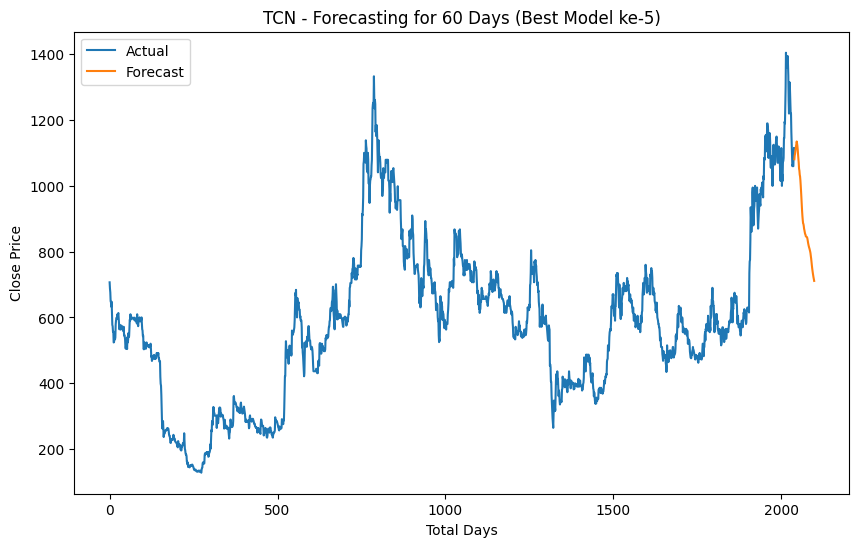

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(data, label='Actual')
plt.plot(range(len(data), len(data) + 60), forecast5, label='Forecast')
plt.xlabel('Total Days')
plt.ylabel('Close Price')
plt.title('TCN - Forecasting for 60 Days (Best Model ke-5)')
plt.legend()
plt.show()